# Assignment — Community Detection

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from zlib import adler32

In this assignment, we try to detect communities in Les Miserables graph.

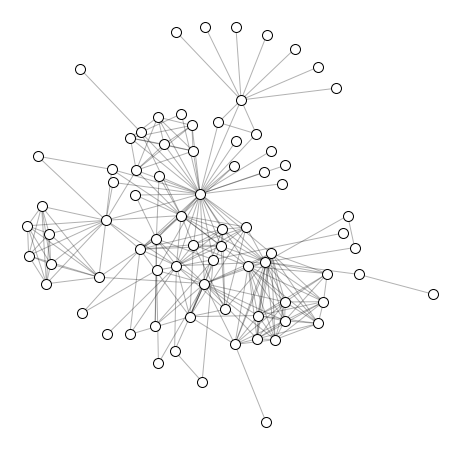

In [2]:
G = nx.Graph()
G.add_edges_from(nx.les_miserables_graph().edges)
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_color='white', edgecolors='black', node_size=100)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.axis('off')
plt.show()

### Task 1. k-core decomposition (1 point)

Let us apply k-core decomposition from networkx. Use `nx.core_number` and colorize every node by its k-shell.

Write a function `k_core_decompose` that takes a graph `G` and returns a np.array with k of node's k-shell. For example, if there are node 1, 2, 3, 4 and nodes 1 is in 1-shell, nodes 2, 3, 4 are in 2-shell, then the output will be [1, 2, 2, 2].

In [3]:
def k_core_decompose(G):
    return np.fromiter(nx.core_number(G).values(), int)

In [4]:
labels = k_core_decompose(G)
assert labels.shape == (77,)
assert labels.min() == 1
assert labels.max() == 9
assert labels[10] == 8
assert labels[65] == 9

Let us draw k-shells of the graph in some k-cores.

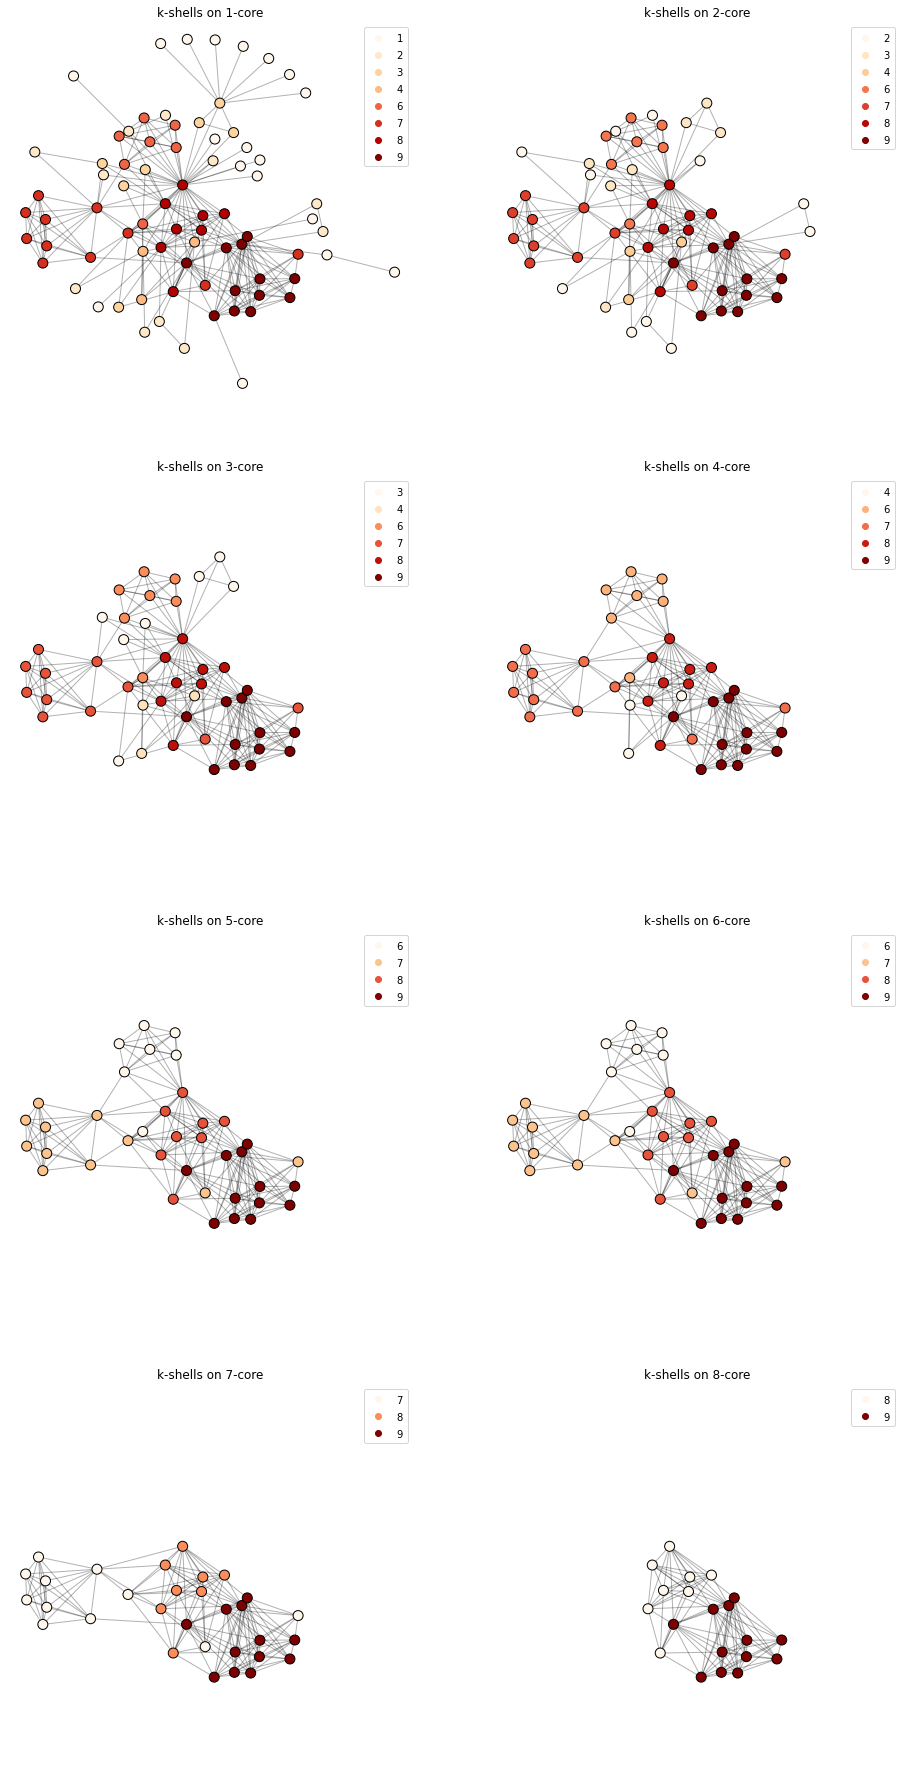

In [5]:
plt.figure(figsize=(8*2, 8*4))

x_max, y_max = np.array(list(pos.values())).max(axis=0)
x_min, y_min = np.array(list(pos.values())).min(axis=0)

for i in range(8):
    plt.subplot(4, 2, i+1)
    subG = nx.k_core(G, i+1)
    nodes = nx.draw_networkx_nodes(
        subG, 
        pos,
        cmap=plt.cm.OrRd,
        node_color=k_core_decompose(subG), 
        node_size=100, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(
        subG, 
        pos,
        alpha=0.3,
        width=1, 
        edge_color='black'
    )
    eps = (x_max - x_min) * 0.05
    plt.xlim(x_min-eps, x_max+eps)
    plt.ylim(y_min-eps, y_max+eps)
    plt.legend(*nodes.legend_elements())
    plt.axis('off')
    plt.title('k-shells on {}-core'.format(i+1))

### Task 2. Clique detection (2 points)

Cluque is a complete subgraph — a simple model of a community. Find the largest cliques in the graph by `nx.find_cliques` and visualize them.

Write a function `largest_cliques` that takes a graph and finds the largest cliques of the same size and collect colors and widths by the following rule: all nodes are white except of nodes in the largest cluque, all edges are thin (adjust as you like) except of edges within cliques. The function returns a tuple with 2 np.arrays: 
* rgb np.array has a shape [n, m, 3] where n is a number of cliques, m is a number of nodes, 3 (r, g, b) is a number of values in the interval [0, 1]. 
* width np.array has a shape [n, k] where n is a number of cliques, k is a number of edges. 

Colors are ordered by `G.nodes`, widths are ordered by `G.edges`.

In [172]:
len(list(nx.find_cliques(G)))

59

In [178]:
def largest_cliques(G):
    cliques = list(nx.find_cliques(G))
    
    max_len = len(max(cliques, key=len))
    largest_cliques = [clique for clique in cliques if len(clique) == max_len]
    print(set(sum(largest_cliques, [])))

    n = len(largest_cliques)
    m = len(G.nodes)
    k = len(G.edges)
    
    rgb = np.zeros((n, m, 3))
    width = np.zeros((n, k))
    
    
#     rgb = np.full((n, m, 3), 1.)
#     width = np.full((n, k), 1.)    
#     rgb = np.full((n, m, 3), 0.0)
#     width = np.full((n, k), 0.1)
    
#     largest_cliques_idx = [i for i, clique in enumerate(cliques) if len(clique) == max_len]
    
#     rgb[largest_cliques_idx] = 1.
#     width[largest_cliques_idx] = 1.
    
    return rgb, width

In [179]:
colors, widths = largest_cliques(G)
assert colors.shape == (2, 77, 3)
size = np.unique(colors[0], axis=0, return_counts=True)[1][0]
assert size == 10
assert np.unique(colors[1], axis=0, return_counts=True)[1][0] == 10
assert ((colors.sum(axis=2) < 3)[0] & (colors.sum(axis=2) < 3)[1]).sum() == 8
assert widths.shape == (2, 254)
assert np.unique(widths[0], axis=0, return_counts=True)[1][1] == 45
assert np.unique(widths[1], axis=0, return_counts=True)[1][1] == 45
assert ((widths == widths.min())[0] & (widths == widths.min())[1]).sum() == 192

{'Gavroche', 'Feuilly', 'Enjolras', 'Courfeyrac', 'Combeferre', 'Prouvaire', 'Bahorel', 'Grantaire', 'Mabeuf', 'Joly', 'Marius', 'Bossuet'}


AssertionError: 

Let us draw a few examples of found cliques.

In [ ]:
plt.figure(figsize=(8*2, 8))

for i in range(colors.shape[0]):
    
    b_edges = np.array(list(G.edges))[widths[i] == widths[i].max()]
    
    plt.subplot(1, 2, i+1)
    nodes = nx.draw_networkx_nodes(
        G, 
        pos,
        node_color=colors[i], 
        node_size=100, 
        linewidths=1, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(
        G,
        pos,
        alpha=0.3,
        width=widths[i].min()
    )
    nx.draw_networkx_edges(
        G,
        pos,
        width=widths[i].max(),
        edgelist=b_edges
    )
    plt.title('Clique of the size {}'.format(size))
    plt.axis('off')

### Task 3. Girvan Newman algorithm, edge betweenness (1 point)

Let us apply Girvan Newman algorithm with edge betweenness. The idea is we cut edges with highest betweenness until the graph becomes disconnected. Use `nx.algorithms.community.girvan_newman` to find communities.

Write a function `edge_betweenness` that takes a graph and the number of divisions and returns np.array of (integer) labels of nodes in each iteration. The shape of the output is [n, m] where n is a number of iteration and m is a number of nodes.

In [6]:
def edge_betweenness(G, n):
    com_gen = nx.algorithms.community.girvan_newman(G)
    labels = []
    for i in range(n):
        communities = next(com_gen)
        c_com = []
        for node in G.nodes:
            for i, c in enumerate(communities):
                if node in c:
                    c_com.append(i)
        labels.append(c_com)
    return np.array(labels)

In [7]:
labels = edge_betweenness(G, 6)
assert labels.shape == (6, 77)
assert np.unique(labels[0]).shape == (2,)
assert np.unique(labels[0]).shape[0] < np.unique(labels[1]).shape[0] < np.unique(labels[5]).shape[0]
assert labels[5][22] == labels[5][23]
assert labels[5][31] == labels[5][34]

Let us draw Girvan Newman algorithm step-by-step.

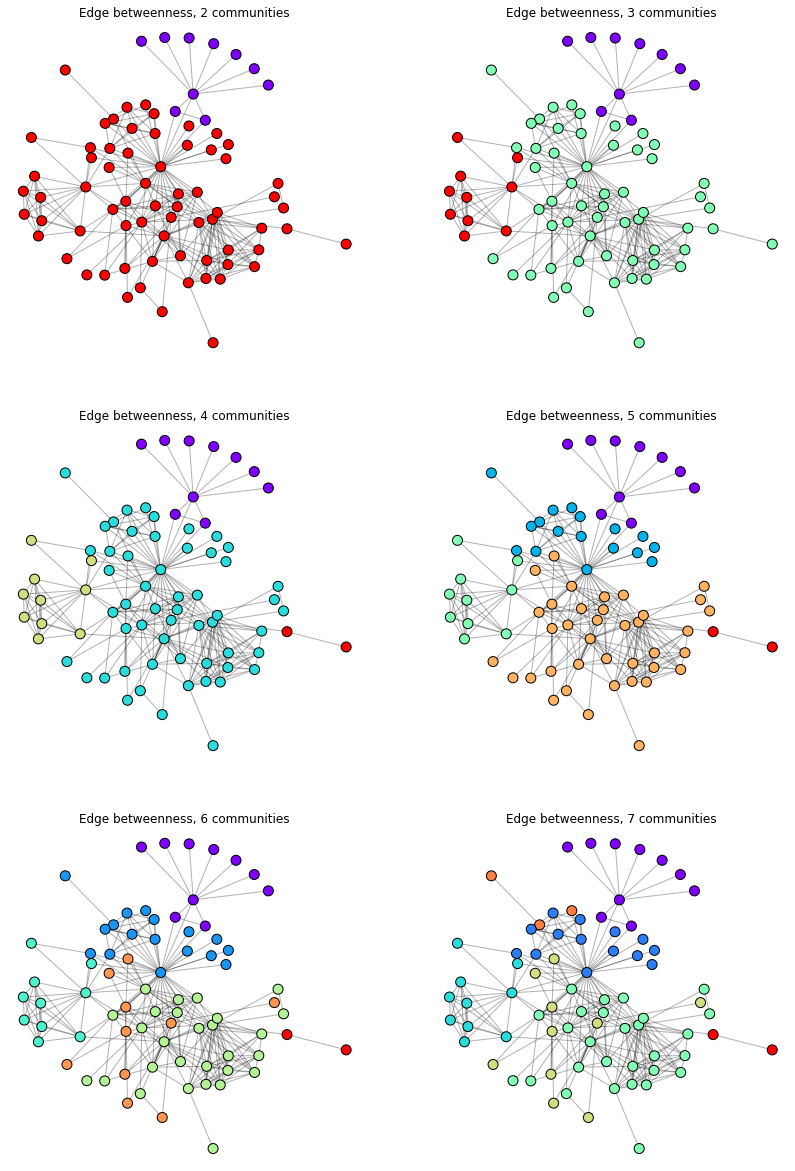

In [8]:
plt.figure(figsize=(7*2, 7*3))
colors = edge_betweenness(G, 6)
for i in range(colors.shape[0]):
    plt.subplot(3, 2, i+1)
    nx.draw_networkx_nodes(
        G, 
        pos,
        cmap=plt.cm.rainbow,
        node_color=colors[i], 
        node_size=100, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title('Edge betweenness, {} communities'.format(i+2))
    plt.axis('off')

### Task 4. Modularity (1 point)

Modularity helps to decide when to stop splitting the graph. The large modularity, the better partitioning. Let us see how modularity changes during division.

Write a function `edge_betw_modularity` that takes a graph, number of iterations of Girvan Newman algorithm and returns a np.array with modularity after each iteration. Use `nx.algorithms.community.modularity`.

In [10]:
def edge_betw_modularity(G, n):
    return np.array([nx.algorithms.community.modularity(G, x) for _, x in 
                     zip(range(n), nx.algorithms.community.girvan_newman(G))])

In [11]:
n_iterations = 20
modularity = edge_betw_modularity(G, n_iterations)
assert modularity.shape == (n_iterations, )
assert round(modularity[0], 4) == 0.0746
assert round(modularity[7], 4) == 0.4519

Let us draw dependency between a number of iteration and modularity.

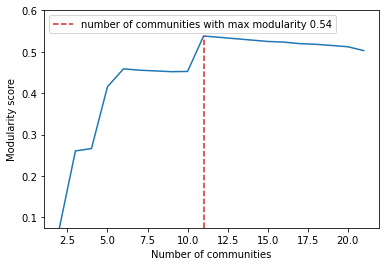

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(n_iterations)+2, modularity)
best_n = np.argmax(modularity) + 2
label = 'number of communities with max modularity {:.2f}'.format(max(modularity))
plt.plot(
    [best_n, best_n], [min(modularity), max(modularity)], 
    'k--', c='tab:red', 
    label=label
)
plt.ylabel('Modularity score')
plt.xlabel('Number of communities')
plt.legend(loc='upper left')
plt.ylim((modularity.min(), 0.6))
plt.show()

### Task 5. Eigenvalues of graph Laplacian (2 points)

There are a few auxiliary methods for graph generation.

In [13]:
def ring_lattice(n, k):
    G = nx.Graph()
    nodes = list(range(n))
    for i in range(1, int(k/2 + 1)):
        targets = nodes[i:] + nodes[:i]
        G.add_edges_from(zip(nodes, targets))
    return G

In [14]:
def pair_graph(n):
    G = nx.disjoint_union(nx.complete_graph(n), nx.complete_graph(n))
    G.add_edge(0, n)
    return G

In [15]:
def triple_graph(n):
    G = nx.disjoint_union_all(
        [nx.complete_graph(n), nx.complete_graph(n), nx.complete_graph(n)]
    )
    G.add_edge(0, n)
    G.add_edge(n, n*2)
    G.add_edge(n*2, 0)
    return G

Graph Laplacian is

$$L = D - A$$

where $A$ is an adjacency matrix and $D$ is a diagonal matrix with node degrees. Eigenvalues and eigenvectors of Laplacian can give us information about structure of a graph. Let us see a few simple examples.

Write a function `eig_laplacian` that takes a graph and returns a tuple with 2 np.arrays: eigenvectors and eigenvalues of Laplacian. The both are ordered in ascending of eigenvalues. 

_Hints: any symmetric matrix has only real eigenvalues and eigenvectors. You can use `np.linalg.eigh` to calculate eigenvectors and eigenvalues in a symmetric matrix._

In [141]:
def eig_laplacian(G):
    D = np.diag([val for (node, val) in G.degree()])
    A = nx.adjacency_matrix(G).todense()
    vals, vecs = np.linalg.eigh(D - A)
    return vecs, vals

In [142]:
emptyG = nx.empty_graph(10)
vecs, vals = eig_laplacian(emptyG)
assert vecs.sum() == 10
assert vals.sum() == 0
oneedgeG = nx.empty_graph(10)
oneedgeG.add_edge(0, 1)
vecs, vals = eig_laplacian(oneedgeG)
assert abs(vecs.round(4)[0, -1]) == abs(vecs.round(4)[1, -1]) == 0.7071
assert vals[0] < vals[-1]
vecs, vals = eig_laplacian(nx.complete_graph(10))
assert (vals == vals.real).sum() == vals.shape[0]
assert (vecs == vecs.real).sum() == vals.shape[0]**2
vecs, vals = eig_laplacian(ring_lattice(10, 2))
assert adler32(vals.round(4)[-1]) == 6815825
assert adler32(vals.round(4)[-2]) == 393479360

Consider some simple graphs and their Laplacian eigenvalues.

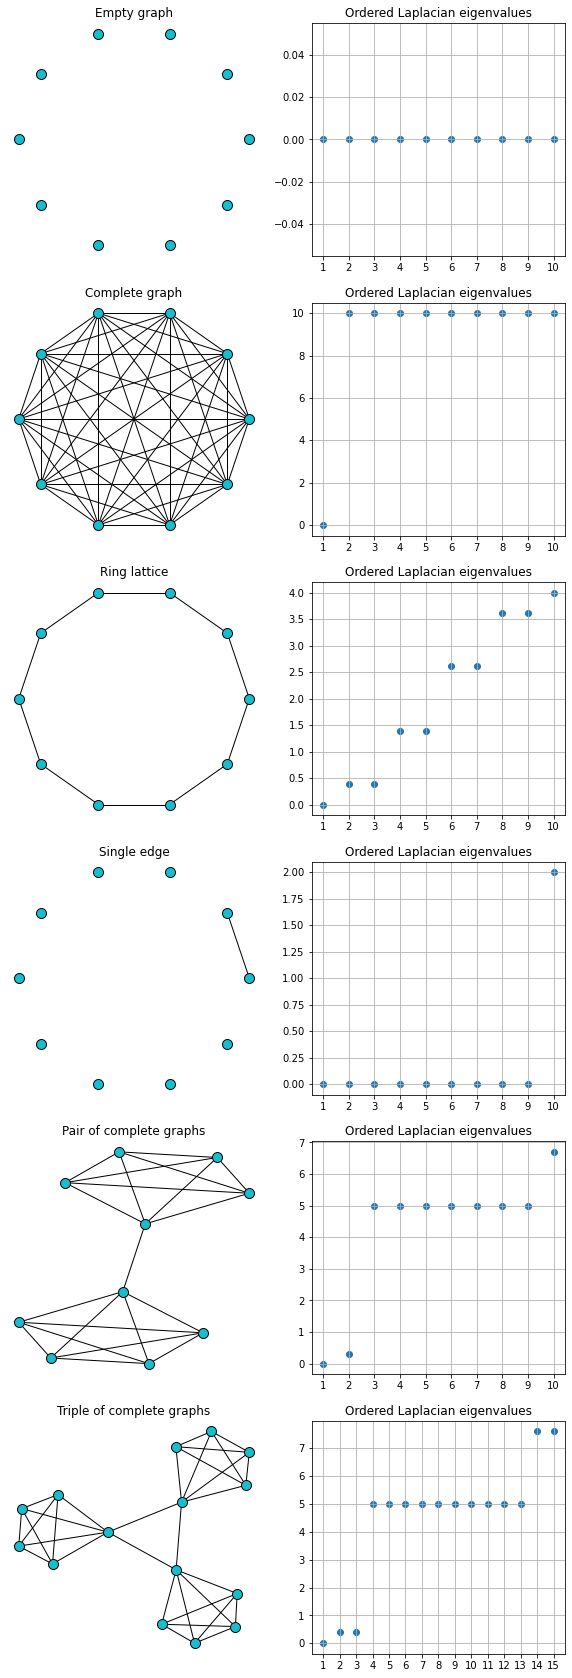

In [143]:
cases = []
cases.append([emptyG, 'Empty graph', nx.draw_circular])
cases.append([nx.complete_graph(10), 'Complete graph', nx.draw_circular])
cases.append([ring_lattice(10, 2), 'Ring lattice', nx.draw_circular])
cases.append([oneedgeG, 'Single edge', nx.draw_circular])
cases.append([pair_graph(5), 'Pair of complete graphs', nx.draw_kamada_kawai])
cases.append([triple_graph(5), 'Triple of complete graphs', nx.draw_kamada_kawai])

plt.figure(figsize=(5*2, 5*6))
i = 1
for iterG, title, designer in cases:
    plt.subplot(6, 2, i)
    i += 1
    designer(iterG, 
             node_color='tab:cyan', 
             edgecolors='black', 
             node_size=100)
    plt.title(title)
    plt.subplot(6, 2, i)
    i += 1
    vecs, vals = eig_laplacian(iterG)
    plt.scatter(np.arange(1, len(iterG) + 1), vals)
    plt.grid()
    plt.xticks(np.arange(1, len(iterG) + 1))
    plt.title('Ordered Laplacian eigenvalues')

We can observe that a number of zero eigenvalues is a number of connected component. $\lambda_2 = n$ in a complete graph. Also, the largest gap between eigenvalues indicates an optimal number of clusters. For example, the largest gap in a complete graph is between 1 and 2, then an optimal number of clusters is 1. Similarly, 2-3 gap is related to a pair graph, and 3-4 gap is related to a triple graph.

### Task 6. Spectral clustering (1 point)

Spectral clustering is a very powerful algorithm for community detection that minimize graph cuts. It is based on Laplacian eigenvectors, in particular a sign of the second smallest eigenvector determines the partition of a graph into two clusters. Consider the following artificial dataset.

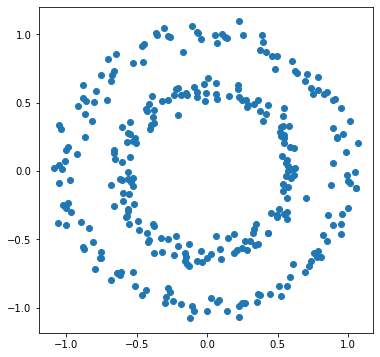

In [117]:
circles, truth_labels = datasets.make_circles(n_samples=300, factor=0.6, 
                                              noise=0.05, random_state=0)
plt.figure(figsize=(6, 6))
plt.scatter(circles[:, 0], circles[:, 1])
plt.show()

Let us isolate data points in center circle using spectral clustering. Any distance based dataset can be represented as a graph with edges between neighbors.

Write a function `custom_graph` that takes a np.array with x-y data points and returns a connected graph. 

_Hint: try to apply `sklearn.neighbors.kneighbors_graph`._

_Remark: you can introduce your own distance_

In [144]:
def custom_graph(data):
    from sklearn.neighbors import kneighbors_graph
    neighbors = kneighbors_graph(circles, 40).todense()
    return nx.from_numpy_matrix(neighbors)

In [145]:
circles, truth_labels = datasets.make_circles(n_samples=300, factor=0.6, 
                                              noise=0.05, random_state=0)
circlesG = custom_graph(circles)
assert circlesG.number_of_nodes() == 300
assert nx.is_connected(circlesG)

Let us draw values in second smallest eigenvector of Laplacian.

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 300 and the array at index 1 has size 1

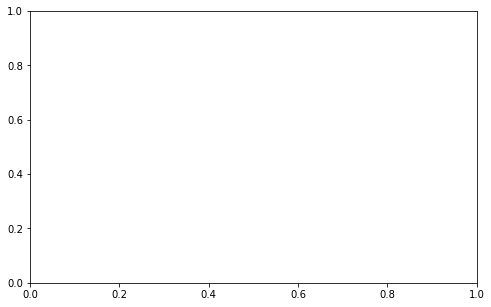

In [146]:
vecs, vals = eig_laplacian(circlesG)

plt.figure(figsize=(8, 5))
plt.scatter(np.arange(300), vecs[:, 1], s=10)
plt.title('Second smallest eigenvector')
plt.xlabel('Data point')
plt.ylabel('Value')
plt.grid()
plt.show()

Next, write a function `spectral_two_clusters` that takes np.array with ordered eigenvectors and returns np.array with labels of nodes.

In [156]:
def spectral_two_clusters(vecs):
    mdl = AgglomerativeClustering(n_clusters=2)
    mdl.fit(vecs)
    return mdl.predict(vecs)

In [157]:
circles, truth_labels = datasets.make_circles(n_samples=300, factor=0.6, 
                                              noise=0.05, random_state=0)
circlesG = custom_graph(circles)
vecs, vals = eig_laplacian(circlesG)
labels = spectral_two_clusters(vecs)

assert abs(np.corrcoef(truth_labels, labels)[0, 1]) > 0.95

plt.figure(figsize=(6, 6))
plt.scatter(circles[:, 0], circles[:, 1], c=labels)
plt.title('Correlation: {:.2f}'.format(abs(np.corrcoef(truth_labels, labels)[0, 1])))
plt.show()

AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'

_Remark: there are two directions of graph construction: selection pairs of nodes to connect to each other, and choosing the weights of created edges. Set `factor=0.7` in `datasets.make_circles` and test yourself — try to achive 0.9 correlation. Combine `sklearn.neighbors.kneighbors_graph` with `scipy.spatial.distance_matrix` or `sklearn.metrics.pairwise.rbf_kernel`. Details are [here](http://www2.imm.dtu.dk/projects/manifold/Papers/Laplacian.pdf)._

### Task 7. Laplacian Eigenmaps (1 point)

In the previous task, we saw how to split a graph into two parts. Let us consider a way to get more parts in the following graph.

In [ ]:
quadG = nx.disjoint_union_all([nx.complete_graph(5), 
                               nx.complete_graph(5),
                               nx.complete_graph(5),
                               nx.complete_graph(5)])
quadG.add_edge(0, 5)
quadG.add_edge(6, 10)
quadG.add_edge(11, 16)
quadG.add_edge(17, 1)

plt.figure(figsize=(5, 5))
nx.draw_kamada_kawai(
    quadG, 
    node_color='white', 
    edgecolors='black', 
    node_size=100)

Further splitting can be performed by different approaches. For example, we can repeat the clustering procedure on the both subgraphs separetely and choose a minimal graph cut and then repeat it again. Another way is to get Laplacian Eigenmaps and then apply KMeans. Let us consider how it works.

1. Compute normalized Laplacian
$$L = D^{-1/2}(D - A)D^{-1/2}$$
2. Stack eigenvectors $L$ into the matrix $(x_1, x_2, \dots)$ in ascending order of eigenvalues
3. Multiply i-th row by $\frac{1}{\sqrt{d_i}}$ where $d_i$ is a node degree
* $k$ vectors of the matrix starting from the second one is _Laplacian Eigenmaps (Spectral Embedding)_
4. Put eigenmaps into KMeans
5. Label nodes by fitted KMeans

Write a function `norm_laplacian` that takes an adjacency matrix `A` and returns a tuple with 2 np.arrays. The first is a normalized Laplacian, the second is a degree sequence.

In [ ]:
def norm_laplacian(A):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
A = nx.to_numpy_array(quadG)
L, degree_seq = norm_laplacian(A)
assert degree_seq.shape == (20, )
assert L.shape == (20, 20)
assert np.diagonal(L).sum() == 20
assert round(L[:, 2].sum(), 4) == 0.0528

Write a function `spectral_embedding` that takes np.array with normalized Laplacian, np.arrays with degree sequence and returns np.array with Laplacian Eigenmaps. `n_components` is a number of vectors of the output.

In [ ]:
def spectral_embedding(L, degree_seq, n_components):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
embedding = spectral_embedding(L, degree_seq, 3)
assert embedding.shape == (20, 3)
assert embedding[:, 0].max() > 0
assert embedding[:, 0].min() < 0
assert embedding[:, 1].max() > 0
assert embedding[:, 1].min() < 0
assert (embedding[:, 0] > 0).sum() == 10
assert (embedding[:, 1] > 0).sum() == 10
assert (embedding[:, 2] > 0).sum() == 10

Let us look at a pairplot of the spectral embedding.

In [ ]:
def spectral_clustering(G, n_clusters, n_components):
    A = nx.to_numpy_array(G)
    L, degree_seq = norm_laplacian(A)
    embedding = spectral_embedding(L, degree_seq, n_components)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    return kmeans.labels_

In [ ]:
embedding = spectral_embedding(L, degree_seq, 3)
labels = spectral_clustering(quadG, 4, 3)
assert np.all(labels[:5] == labels[0])
assert np.all(labels[5:10] == labels[5])
assert np.all(labels[10:15] == labels[10])
assert np.all(labels[15:20] == labels[15])

In [ ]:
embedding = spectral_embedding(L, degree_seq, 3)
labels = spectral_clustering(quadG, 4, 3)
pair_data = pd.DataFrame(
    np.hstack([embedding, labels[:, None]]), 
    columns=['x2', 'x3', 'x4', 'label'])
pair_data.label = pair_data.label.astype('str')
p = sns.pairplot(
    pair_data,
    hue='label',
    diag_kind=None
)
p._legend.remove()
plt.show()

We can see four distinct clusters in the plots, that is why we use KMeans, but other clustering algorithms can also be applied here.

In [ ]:
plt.figure(figsize=(5, 5))
nx.draw_kamada_kawai(
    quadG, 
    cmap=plt.cm.rainbow,
    node_color=labels, 
    edgecolors='black', 
    node_size=100)

Finally, let us see how spectral clustering works on the Les Miserables graph.

In [ ]:
plt.figure(figsize=(8, 8))
nodes = nx.draw_networkx_nodes(
    G, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=spectral_clustering(G, 6, 5), 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)
nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.2,
    edge_color='black'
)
plt.axis('off')
plt.legend(*nodes.legend_elements())
plt.show()

### Task 8. Agglomerative clustering (1 point)

Agglomerative clustering is an iterative procedure that unions similar clusters using a similarity matrix, but since we will run `sklearn.cluster.AgglomerativeClustering`, we need to pass a _distance_ matrix. So, first we need to choose a similarity measure and then convert it into a distance. Let us do it via SimRank measure that is defined as follows: _two objects are considered to be similar if they are referenced by similar objects_. Since SimRank takes values on the interval [0, 1], let us define a distance as

$$\text{Distance}= 1 - \text{SimRank}$$

Write a function `simrank_distance` that takes a graph and returns a distance matrix based on SimRank. Use `nx.simrank_similarity_numpy`. The distance matrix should be _absolutely_ symmetric.

In [167]:
def simrank_distance(G):
    return 1 - nx.simrank_similarity_numpy(G, max_iterations=10000, tolerance=0)

In [168]:
distance = simrank_distance(G)
assert distance.shape == (77, 77)
assert np.diagonal(distance).sum() == 0
assert np.allclose(distance, distance.T, rtol=0, atol=0)
assert distance[52, 68] <= distance[1, 19]
assert distance[45, 29] <= distance[38, 46]

AssertionError: 

Then let us cluster nodes using `scipy.cluster.hierarchy.linkage`. The method takes distancies and returns an np.array with a matrix `Z` where every i-th row consists of
* `Z[i, 0]` and `Z[i, 1]` are indexes of combined clusters
* `Z[i, 2]` is the distance between combined clusters
* `Z[i, 3]` is the number of observations in combined clusters

Cluster with an index `n+i` is described in a i-th row of the matrix `Z`. Clusters with indexes less than `n+1` are initial nodes. The method `scipy.cluster.hierarchy.dendrogram` uses the matrix `Z` to plot a dendrogram. Let us look at a dendrogram of Les Miserables graph.

In [ ]:
plt.figure(figsize=(16, 6))
linked = linkage(squareform(distance), 'complete')
dendrogram(linked, labels=list(G.nodes), 
           leaf_font_size=12)
plt.plot([0, 800], [0.89, 0.89], 'k--', c='tab:red')
plt.show()

Then we need to select a horizontal line that gives us a partitioning of the graph. There are two approaches: select the number of clusters, and select the maximal distance between clusters. For example, if we select a horicontal line with maximal distance 0.89 (a red line on the plot) then the number of clusters will be 4.

Write a function `agglomerative_clustering` that takes a distance matrix, maximal distance between clusters and returns an np.array with labels of clusters. Use `sklearn.cluster.AgglomerativeClustering` with complete linkage.

In [ ]:
def agglomerative_clustering(distance, max_distance):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
assert len(set(agglomerative_clustering(distance, 0.8))) == 17
assert len(set(agglomerative_clustering(distance, 0.89))) == 4

On the graph with maximal distance 0.87

In [ ]:
labels = agglomerative_clustering(distance, 0.87)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(
    G, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=labels, 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)
nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.2,
    edge_color='black'
)
plt.axis('off')
plt.show()